## **Content Based and Collaborative filtering Movie Recommendation System**
---
## **Group 7**

**Student Names:**  
- Alex Mwera  
- Noel Seda  
- Zena Lisa Karari  

**Student Pace:** Part-time  
**Instructor Name:** Mildred Jepkosgei


---

### Table of Contents
1. Business Understanding  
2. Problem Statement  
3. Data Understanding  
4. Data Preprocessing  
5. Exploratory Data Analysis (EDA)  
6. Content Based Modelling      
7. Top-5 Recommendation Generation  
8. Conclusion and Final Recommendations  

---


### 1. Business Understanding

### Objective
To improve user satisfaction and engagement on a movie streaming platform by providing **Top 5 personalised movie recommendations** based on users' past ratings. The goal is to simulate how platforms like Netflix and Prime Video tailor suggestions to each user.

### Scope
This project uses the MovieLens `ml-latest-small` dataset. It focuses on:
- Explicit rating data (0.5 to 5.0 scale)
- Recommending unseen movies to users

### Success Criteria

| Metric                 | Goal                            |
|------------------------|----------------------------------|
| RMSE / MAE             | Below 1.0                        |
| Recommendation Relevance | Top 5 suggestions match user interests |
| Coverage               | Recommendations generated for most users |
| Scalability            | Can extend to larger datasets or real-world scenarios |



### 2. Problem Statement

In the age of digital content, users are often overwhelmed by thousands of movie choices. Without a guiding system, users may miss out on films they would have enjoyed, leading to reduced satisfaction and platform engagement.

> **How can we accurately recommend the Top 5 movies to a user based on their historical movie ratings using content-based filtering techniques?**

This project aims to build such a recommender system using content based filtering, trained on historical ratings data from MovieLens.



### 3. Data Understanding

The dataset used is the `ml-latest-small` version from MovieLens, containing 100,836 ratings by 610 users across 9,742 movies.

### Key Files:
- `movies.csv` – Contains `movieId`, `title`, `genres`
- `ratings.csv` – Contains `userId`, `movieId`, `rating`, `timestamp`
- `tags.csv`  – Contains user-generated tags
- `links.csv`  – External references (IMDb, TMDb)

### Ratings Data:
- Ratings range from 0.5 to 5.0 in 0.5 increments
- Explicit feedback format



### 4. Data Preprocessing

- Removed duplicates and unnecessary fields
- Converted data into a **user-item matrix**
- Split data into **training and test sets**
- Normalized data for similarity calculations

---

## **Implementation & Demonstration**

### 1. Environment Setup  
Import libraries for data handling and visualization.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### 2. Load Dataset  
Loading MovieLens data files (`movies.csv`, `ratings.csv`,`links.csv`,`tags.csv`) into a dictionary.


In [2]:
# Define file directory and filenames
base_path = "ml-latest-small"
filenames = {
    "movies": "movies.csv",
    "links": "links.csv",
    "ratings": "ratings.csv",
    "tags": "tags.csv"
}

# Load all CSV files into a dictionary
data = {}

for name, file in filenames.items():
    file_path = os.path.join(base_path, file)
    try:
        data[name] = pd.read_csv(file_path)
        print(f"Loaded {name} ({data[name].shape[0]} rows, {data[name].shape[1]} columns)")
    except FileNotFoundError:
        print(f"Warning: File '{file_path}' not found.")



Loaded movies (9742 rows, 3 columns)
Loaded links (9742 rows, 3 columns)
Loaded ratings (100836 rows, 4 columns)
Loaded tags (3683 rows, 4 columns)


Understanding the Dataset 

In [3]:
# Print the shape of each dataset
for name, df in data.items():
    print(f"{name.capitalize()} dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")


Movies dataset: 9,742 rows, 3 columns
Links dataset: 9,742 rows, 3 columns
Ratings dataset: 100,836 rows, 4 columns
Tags dataset: 3,683 rows, 4 columns


In [4]:
for name, df in data.items():
    print(df.head(1))

   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
   movieId  imdbId  tmdbId
0        1  114709   862.0
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
   userId  movieId    tag   timestamp
0       2    60756  funny  1445714994


In [5]:
movies_df = data['movies']
links_df = data['links']
ratings_df = data['ratings']
tags_df = data['tags']

### 3. Merging Datasets

To prepare the data for analysis and recommendations, we merge the `ratings`,`links`,`tags`and `movies` datasets.  
This will allow us to connect user ratings with movie titles and genres for further processing.


In [6]:
ratings_movies = pd.merge(ratings_df, movies_df, on='movieId', how='left')

In [7]:
ratings_movies_tags = pd.merge(ratings_movies, tags_df, on=['userId', 'movieId'], how='left')

In [8]:
movies_full_data = pd.merge(ratings_movies_tags, links_df, on='movieId', how='left')

In [9]:
print("Merged dataset shape:", movies_full_data.shape)
print("Columns:", movies_full_data.columns.tolist())

Merged dataset shape: (102677, 10)
Columns: ['userId', 'movieId', 'rating', 'timestamp_x', 'title', 'genres', 'tag', 'timestamp_y', 'imdbId', 'tmdbId']


In [10]:
# Rename for clarity
movies_full_data.rename(columns={
    'timestamp_x': 'rating_timestamp',
    'timestamp_y': 'tag_timestamp'
}, inplace=True)


In [11]:
movies_full_data.head()

,userId,movieId,rating,rating_timestamp,title,genres,tag,tag_timestamp,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,114709,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN,113228,15602.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN,113277,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN,114369,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN,114814,629.0


### 4. Data Cleaning

Before building the recommendation model, we perform basic data cleaning to ensure quality and consistency.  
This includes:

-  Removing duplicate entries 
-  Handling missing values  
-  Ensuring correct data types  

These steps help reduce noise and improve the accuracy of our recommendations.


In [12]:
movies_full_data.isnull().sum()

userId                  0
movieId                 0
rating                  0
rating_timestamp        0
title                   0
genres                  0
tag                 99201
tag_timestamp       99201
imdbId                  0
tmdbId                 13
dtype: int64

In [13]:
movies_full_data['tmdbId'] = movies_full_data['tmdbId'].fillna(-1)
movies_full_data['tmdbId'] = pd.to_numeric(movies_full_data['tmdbId'], downcast='integer')


In [14]:
movies_full_data.drop_duplicates(inplace=True)
movies_full_data.duplicated().sum()

0

In [15]:
movies_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   userId            102677 non-null  int64  
 1   movieId           102677 non-null  int64  
 2   rating            102677 non-null  float64
 3   rating_timestamp  102677 non-null  int64  
 4   title             102677 non-null  object 
 5   genres            102677 non-null  object 
 6   tag               3476 non-null    object 
 7   tag_timestamp     3476 non-null    float64
 8   imdbId            102677 non-null  int64  
 9   tmdbId            102677 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(3)
memory usage: 7.4+ MB


In [16]:
# Converting user IDs and tmdbId to object data type
movies_full_data[['userId', 'tmdbId']] = movies_full_data[['userId', 'tmdbId']].astype('object')
movies_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   userId            102677 non-null  object 
 1   movieId           102677 non-null  int64  
 2   rating            102677 non-null  float64
 3   rating_timestamp  102677 non-null  int64  
 4   title             102677 non-null  object 
 5   genres            102677 non-null  object 
 6   tag               3476 non-null    object 
 7   tag_timestamp     3476 non-null    float64
 8   imdbId            102677 non-null  int64  
 9   tmdbId            102677 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 7.8+ MB


##                                                                                                      **Exploratory Data Analysis(EDA)**
---

### 5.Ratings Distribution

We visualized the distribution of movie ratings to understand how users rate movies.  
This helps identify skewness (e.g., most ratings being positive) and guides how we interpret user preferences.


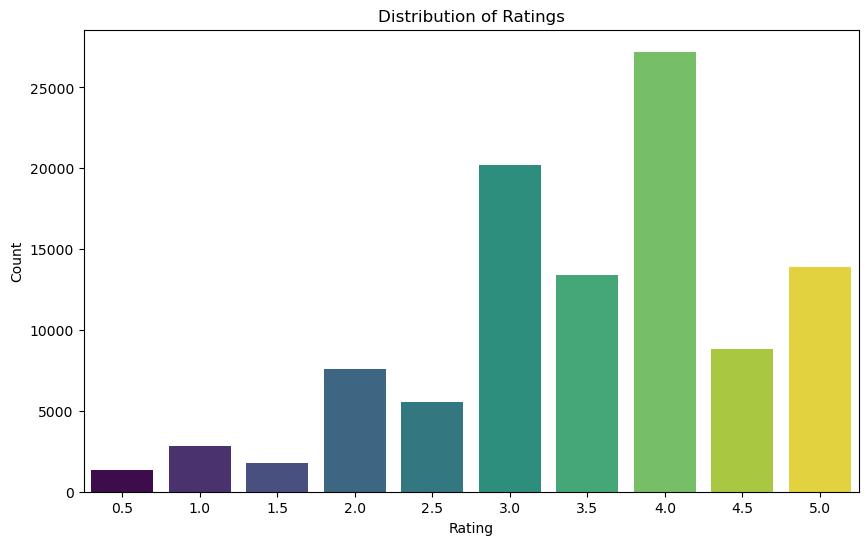

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', hue='rating', data=movies_full_data, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend([], [], frameon=False)  
plt.show()


### 6.Genre Distribution

To understand the type of content available in the dataset, we analyzed the number of movies in each genre.

Since movies can belong to multiple genres (e.g., *Action|Adventure|Sci-Fi*), we split the `genres` column and counted each genre occurrence individually.

The bar chart below shows the number of movies tagged with each genre in the dataset.


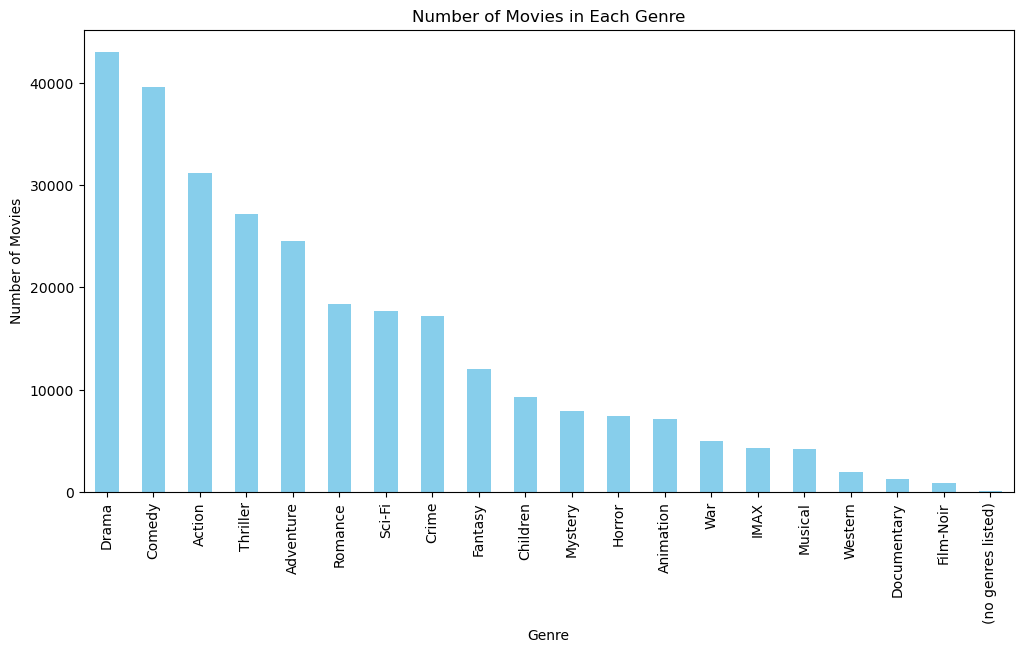

In [18]:
# count of movies in each genre
genre_counts = movies_full_data['genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()

### 7.Ratings Activity Over Time

We convert the `timestamp` column into a human-readable datetime format to analyze trends in rating behavior.

By resampling the data monthly (`resample('M')`), we can observe how the number of ratings has changed over time — which is useful for understanding user engagement patterns and platform activity.


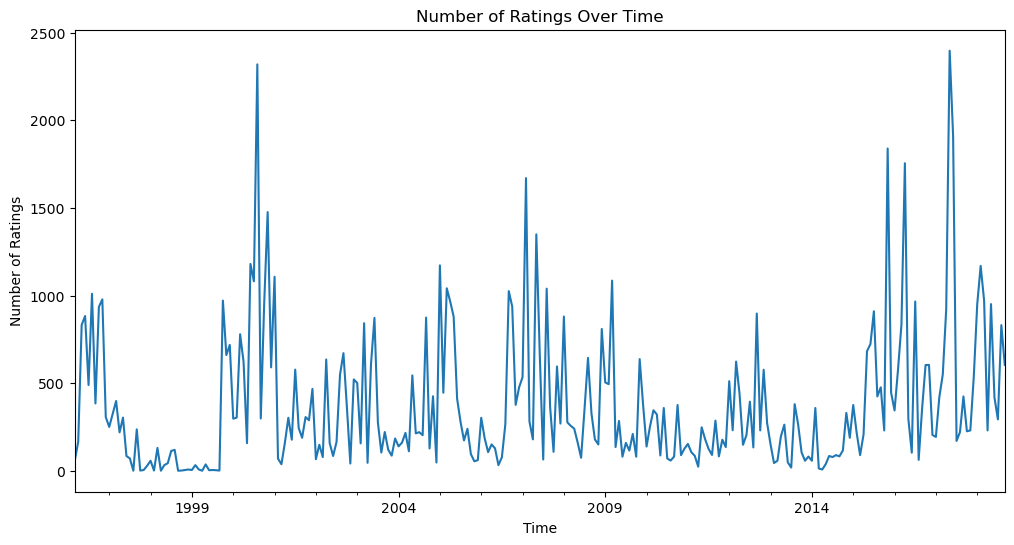

In [19]:
import datetime

ratings = data["ratings"]

# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Plot the number of ratings over time
plt.figure(figsize=(12, 6))
ratings.set_index('timestamp').resample('ME').size().plot()
plt.title('Number of Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.show()

### 8.Most Common Genre Combinations

Movies often belong to more than one genre (e.g., *Action | Adventure | Sci-Fi*).  
To uncover patterns in how genres are combined, we:

- Extracted and sorted genre combinations from each movie.
- Counted how often each unique combination appeared.
- Filtered for combinations that occurred more than 10 times.
- Visualized the top 10 most frequent genre pairings or groupings.

This helps us understand popular multi-genre trends in the dataset, which can inform **content-based recommendations** based on genre similarity.


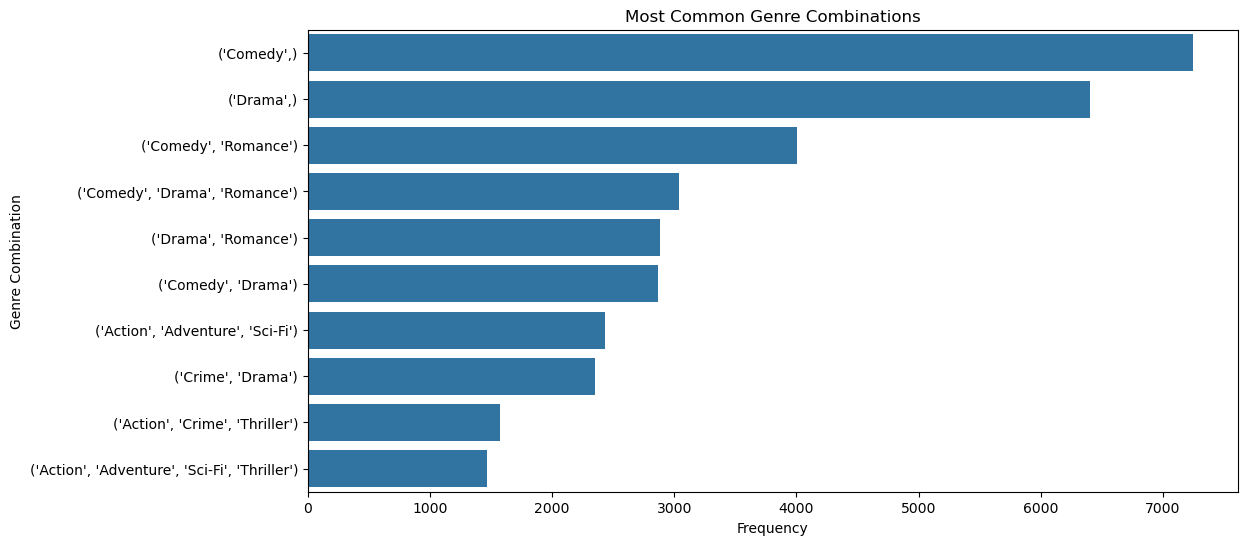

In [20]:
from itertools import combinations
from collections import Counter

genre_combos = movies_full_data['genres'].dropna().apply(lambda x: tuple(sorted(x.split('|'))))
combo_counts = Counter(genre_combos)

# Filter for combinations of 2 or more genres
combo_df = pd.DataFrame(combo_counts.items(), columns=['combo', 'count'])
combo_df = combo_df[combo_df['count'] > 10].sort_values('count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=combo_df['count'], y=combo_df['combo'].astype(str))
plt.title('Most Common Genre Combinations')
plt.xlabel('Frequency')
plt.ylabel('Genre Combination')
plt.show()


## **Content Based Recommender system**
---

In [21]:
movies_full_data = movies_full_data.drop_duplicates(subset='title', keep='first')

In [22]:
movies_full_data.shape

(9719, 10)

In [23]:
movies_full_data['genres']

0         Adventure|Animation|Children|Comedy|Fantasy
1                                      Comedy|Romance
2                               Action|Crime|Thriller
3                                    Mystery|Thriller
4                              Crime|Mystery|Thriller
                             ...                     
102661                                Action|Thriller
102662                             Action|Crime|Drama
102664                          Action|Drama|Thriller
102668                                Horror|Thriller
102669                                         Horror
Name: genres, Length: 9719, dtype: object

### Importing TF-IDF and Cosine Similarity

To build a content-based movie recommender system, we use textual metadata — specifically, the **genres** column — to measure similarity between movies.

- **`TfidfVectorizer`** transforms the genre text into numerical feature vectors based on Term Frequency–Inverse Document Frequency
- **`cosine_similarity`** computes the similarity between these TF-IDF vectors, returning a score between 0 (no similarity) and 1 (identical)


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
print(movies_full_data.columns.tolist())


['userId', 'movieId', 'rating', 'rating_timestamp', 'title', 'genres', 'tag', 'tag_timestamp', 'imdbId', 'tmdbId']


In [26]:
movies_full_data['description'] = movies_full_data['genres'].fillna('') + " " + movies_full_data['tag'].fillna('')


### TF-IDF Vectorizer Setup

We use `TfidfVectorizer` to convert text into numerical features for similarity comparison. Key settings include:

- `min_df=3`: Ignore rare terms.
- `max_features=50`: Limit to top 50 terms.
- `ngram_range=(1, 3)`: Use unigrams, bigrams, and trigrams.
- `stop_words='english'`: Remove common English words.

This helps capture the most meaningful patterns in the text data.


In [27]:
tfv = TfidfVectorizer(min_df=3,  max_features=50, 
                      strip_accents='unicode', analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3),
                      stop_words='english')




In [28]:
# Filling NaNs with empty string
movies_full_data['genres'] = movies_full_data['genres'].fillna('')
# replacing the pipes '|' from the genres with 'commas'
movies_full_data['genres'] = movies_full_data['genres'].map(lambda x: ", ".join(x.split("|")))
# genres
movies_full_data['genres'].head()

0    Adventure, Animation, Children, Comedy, Fantasy
1                                    Comedy, Romance
2                            Action, Crime, Thriller
3                                  Mystery, Thriller
4                           Crime, Mystery, Thriller
Name: genres, dtype: object

### Creating the TF-IDF Matrix

We apply the configured `TfidfVectorizer` to the `genres` column to transform the text data into a sparse matrix of TF-IDF features.  
This matrix numerically represents each movie’s genre profile, ready for similarity calculations.


In [29]:
tfv_matrix = tfv.fit_transform(movies_full_data['genres'])
tfv_matrix

<9719x50 sparse matrix of type '<class 'numpy.float64'>'
	with 33610 stored elements in Compressed Sparse Row format>

In [30]:
# Calculate cosine similarity
cosine_sim = cosine_similarity(tfv_matrix, tfv_matrix)

### `get_title` Function

Finds the first movie title matching the input text (case-insensitive) and returns its title and genres.  
If no match, returns `None`.


In [31]:
def get_title(text, movies_full_data=movies_full_data):
    """Gets movie title matching `text`
    returns:
        title - title of movie matching the input
        genres - the movie's genres 
    """
    mask = movies_full_data['title'].str.contains(text, case=False, regex=False)
    title = movies_full_data.loc[mask, 'title'].head(1).values[0] if any(mask) else None
    
    if not title:
        print(f"\n'{text}' does not match any movies. Please try again")
        return None, None

    return title, movies_full_data.loc[mask].head(1)["genres"].values[0]

In [32]:
# test
print(get_title("Superman (1978)", movies_full_data))
print()
print(get_title("Toy Story (1995)", movies_full_data))

('Superman (1978)', 'Action, Adventure, Sci-Fi')

('Toy Story (1995)', 'Adventure, Animation, Children, Comedy, Fantasy')


### `get_recommendations` Function

Given a movie title, this function finds the top 10 most similar movies based on cosine similarity of their genres.

Returns the recommended movies with their titles, genres, and ratings.


In [33]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies_full_data[movies_full_data['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    return movies_full_data.iloc[movie_indices][['title', 'genres', 'rating']].reset_index(drop=True)

In [34]:
print(get_recommendations('Toy Story (1995)'))

                                               title  \
0                                 Toy Story 2 (1999)   
1                              Monsters, Inc. (2001)   
2                                        Antz (1998)   
3     Adventures of Rocky and Bullwinkle, The (2000)   
4                   Emperor's New Groove, The (2000)   
5                             Shrek the Third (2007)   
6                           The Good Dinosaur (2015)   
7  Asterix and the Vikings (Astérix et les Viking...   
8                     Tale of Despereaux, The (2008)   
9                                       Moana (2016)   

                                            genres  rating  
0  Adventure, Animation, Children, Comedy, Fantasy     4.5  
1  Adventure, Animation, Children, Comedy, Fantasy     4.0  
2  Adventure, Animation, Children, Comedy, Fantasy     3.0  
3  Adventure, Animation, Children, Comedy, Fantasy     4.0  
4  Adventure, Animation, Children, Comedy, Fantasy     4.5  
5  Adventure, Ani

### Saving Model and Data

The dataset, cosine similarity matrix and TF-IDF vectorizer are saved into a pickle file for use in our app.py, enabling quick loading without retraining.


In [35]:
import pickle
with open('movie_recommendation_model.pkl', 'wb') as f:
    pickle.dump({
        'movies_full_data': movies_full_data,
        'cosine_sim': cosine_sim,
        'tfv': tfv
    }, f)

### Conclusion
This project implemented a content-based movie recommendation system using TF-IDF vectorization of movie genres and cosine similarity to suggest movies similar to those a user likes. The system effectively captures movie similarities based on genre information, providing relevant recommendations without relying on user ratings.

While the model performs well for users with specific genre preferences, it is limited by the available metadata and may not capture other aspects such as user behavior or movie popularity.

Additionally, a user interface was built to provide an interactive experience, allowing users to input movie titles and receive personalized recommendations easily.

### Next Steps
To enhance the content-based recommender:

- **Expand Metadata:** Incorporate additional features like movie descriptions, tags, cast, and crew information.
- **Improve Feature Engineering:** Use techniques like word embeddings or sentence transformers for richer content representation.
- **Address Cold Start for New Movies:** Utilize content features to recommend new or less-rated movies.
- **Combine with Collaborative Filtering:** Create a hybrid model for better personalization.
- **Evaluate with User Feedback:** Collect qualitative feedback to assess recommendation relevance.


## **Collaborative Recommender system(Item to Item)**
---

#### Loading and Merging MovieLens Dataset for `item to item` collaborative filtering 

In [36]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

movie_ratings = pd.merge(movies,ratings,).drop(columns=['timestamp','genres'])

movie_ratings.head(10)

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5
5,1,Toy Story (1995),18,3.5
6,1,Toy Story (1995),19,4.0
7,1,Toy Story (1995),21,3.5
8,1,Toy Story (1995),27,3.0
9,1,Toy Story (1995),31,5.0


In [37]:
movie_ratings.shape

(100836, 4)

Transform Ratings Data into User-Movie Matrix

In [38]:
movie_ratings = movie_ratings.pivot_table(index='userId', columns='title', values='rating')
movie_ratings.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 Clean the User-Movie Ratings Matrix

In [39]:
movie_ratings= movie_ratings.dropna (thresh=10,axis=1).fillna(0)
movie_ratings.head(3)

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#Similarity matrix
movie_ratings=movie_ratings.corr(method='pearson')

In [41]:
# Function for recommending movies by weighting user ratings of the given movie based on user preference

def get_similar_movies(movie_name,rating):
    similar_score=movie_ratings[movie_name]*(rating-2.5)
    similar_score=similar_score.sort_values(ascending=False)
    return similar_score
    

In [42]:
#Collecting user input for movies and ratings via console.
def collect_user_input():
    
   
    user_input = []
    print("Enter the movies you’ve watched and your rating (0 to 5). Type 'done' when finished.\n")

    while True:
        movie = input("Enter movie title (or 'done' to finish): ")
        if movie.lower() == 'done':
            break

        if movie not in movie_ratings.columns:
            print("Movie not found in database. Try again.")
            continue

        try:
            rating = float(input(f"Enter your rating for '{movie}': "))
            if 0 <= rating <= 5:
                user_input.append((movie, rating))
            else:
                print("Rating must be between 0 and 5.")
        except ValueError:
            print("Invalid input. Please enter a numeric rating.")

    return user_input




In [43]:
def recommend_from_user_input():
    """
    Uses get_similar_movies() for each user input to compute and display recommendations.
    """
    user_ratings = collect_user_input()

    if not user_ratings:
        print("No valid input provided.")
        return

    # Initializing empty Series for recommendation scores
    similar_movies = pd.Series(dtype=float)

    for movie, rating in user_ratings:
        similar_movies = similar_movies.add(get_similar_movies(movie, rating), fill_value=0)

    # Droping movies the user has already rated
    rated_titles = [m for m, _ in user_ratings]
    similar_movies = similar_movies.drop(labels=rated_titles, errors='ignore')

    # Displaying top recommendations
    recommendations = similar_movies.sort_values(ascending=False).head(10)

    print("\nTop Recommendations for You:\n")
    for i, (title, score) in enumerate(recommendations.items(), start=1):
        print(f"{i}. {title} (Score: {score:.2f})")

    return recommendations


In [47]:
# Collects user-rated movies interactively, uses get_similar_movies() to generate scores and displays top movie recommendations based on combined similarity
recommend_from_user_input()


Enter the movies you’ve watched and your rating (0 to 5). Type 'done' when finished.


Top Recommendations for You:

1. Toy Story 2 (1999) (Score: 1.15)
2. Groundhog Day (1993) (Score: 0.90)
3. Independence Day (a.k.a. ID4) (1996) (Score: 0.90)
4. Willy Wonka & the Chocolate Factory (1971) (Score: 0.89)
5. Mission: Impossible (1996) (Score: 0.88)
6. Nutty Professor, The (1996) (Score: 0.88)
7. Bug's Life, A (1998) (Score: 0.86)
8. Lion King, The (1994) (Score: 0.86)
9. Babe (1995) (Score: 0.85)
10. Monsters, Inc. (2001) (Score: 0.83)


title
Toy Story 2 (1999)                            1.154403
Groundhog Day (1993)                          0.903849
Independence Day (a.k.a. ID4) (1996)          0.896183
Willy Wonka & the Chocolate Factory (1971)    0.893284
Mission: Impossible (1996)                    0.882117
Nutty Professor, The (1996)                   0.875736
Bug's Life, A (1998)                          0.863578
Lion King, The (1994)                         0.860621
Babe (1995)                                   0.852840
Monsters, Inc. (2001)                         0.827033
dtype: float64

### Conclusion

- The get_similar_movies() function recommends movies based on how much a user liked a given film.

- Ratings are weighted relative to a neutral score (2.5) to reflect user preference strength.

- The model identifies movies liked by users with similar tastes and ranks them accordingly.

- This approach is interpretable, easy to implement, and effective for small-to-medium datasets.

### What’s Next?

- Handle Cold Start: Implement solutions for new users or unrated movies using content-based filtering (e.g., genres, tags, or summaries).

- Add User Interface: Build a simple web or desktop interface to make the recommender interactive and user-friendly.

- Hybrid Models: Combine collaborative filtering with content-based approaches or use deep learning for personalized recommendations.

- Evaluation Metrics: Introduce metrics like RMSE, Precision@K, or Recall@K to measure the quality of the recommendations.

- Deploy the System: Wrap your model into an API (e.g., Flask or FastAPI) and deploy it on a cloud platform for real-world use.